### Helper methods

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


def gillespie_ssa(k1, k2, E0, S0, C0, P0, t_max, rng):
    t = 0.0
    E, S, C, P = E0, S0, C0, P0

    times = [t]
    states = [np.array([E, S, C, P], dtype=int)]

    while t < t_max:
        a1 = k1 * E * S          # E + S -> C
        a2 = k2 * C              # C -> E + P
        a0 = a1 + a2

        if a0 <= 0:
            break

        # when
        r1 = rng.random()
        dt = -np.log(r1) / a0
        t += dt

        if t > t_max:
            t = t_max
            times.append(t)
            states.append(np.array([E, S, C, P], dtype=int))
            break

        # Which
        r2 = rng.random()
        if r2 * a0 < a1:
            # R1: E + S -> C
            E -= 1
            S -= 1
            C += 1
        else:
            # R2: C -> E + P
            C -= 1
            E += 1
            P += 1

        times.append(t)
        states.append(np.array([E, S, C, P], dtype=int))

    if times[-1] < t_max:
        times.append(t_max)
        states.append(states[-1].copy())

    return np.array(times), np.vstack(states)

def ode_rhs(t, y, k1, k2):
    E, S, C, P = y
    v1 = k1 * E * S
    v2 = k2 * C

    dE = -v1 + v2
    dS = -v1
    dC = v1 - v2
    dP = v2
    return [dE, dS, dC, dP]

In [2]:
# init
k1 = 0.001
k2 = 0.5

E0 = 100
S0 = 1000
C0 = 0
P0 = 0

t_max = 20.0

rng = np.random.default_rng(seed=0)

# Simulate ensemble of trajectories
n_sims = 500
times_list = []
S_list = []

for i in range(n_sims):
    t_traj, state_traj = gillespie_ssa(k1, k2, E0, S0, C0, P0, t_max, rng)
    times_list.append(t_traj)
    S_list.append(state_traj[:, 1])  # S is the second component

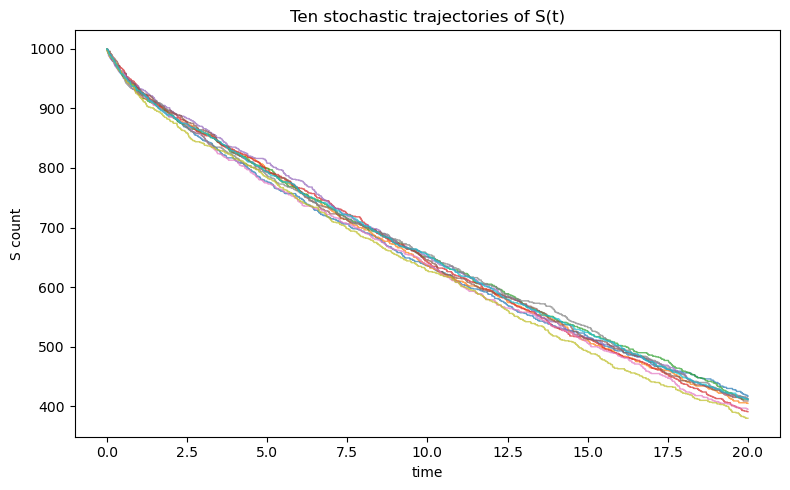

In [3]:
# Plot 10 representative trajectories of S(t)
plt.figure(figsize=(8, 5))
for i in range(10):
    t_traj = times_list[i]
    S_traj = S_list[i]
    plt.step(t_traj, S_traj, where="post", alpha=0.7, linewidth=1)

plt.xlabel("time")
plt.ylabel("S count")
plt.title("Ten stochastic trajectories of S(t)")
plt.tight_layout()
plt.show()

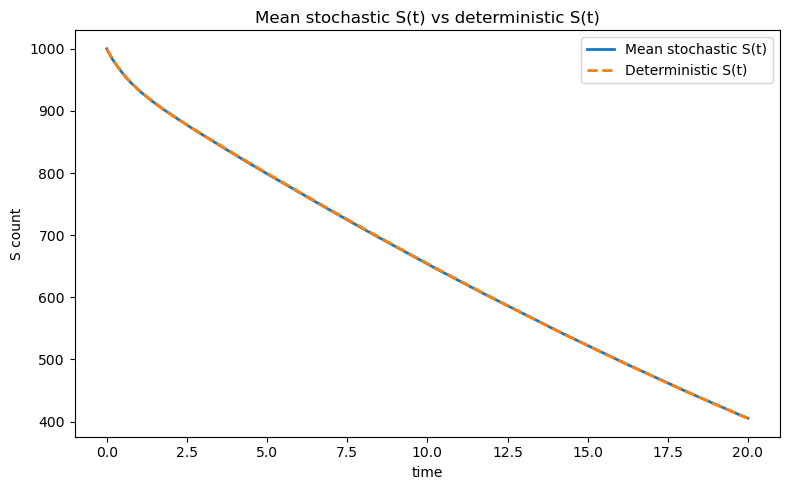

In [4]:
# Interpolate each S(t) onto a common time grid and compute mean
t_grid = np.linspace(0.0, t_max, 1001) 
S_interp = np.empty((n_sims, t_grid.size))

for i in range(n_sims):
    S_interp[i, :] = np.interp(t_grid, times_list[i], S_list[i])

S_mean = S_interp.mean(axis=0)

# Deterministic solution using solve_ivp
y0 = [E0, S0, C0, P0]
sol = solve_ivp(
    fun=lambda t, y: ode_rhs(t, y, k1, k2),
    t_span=(0.0, t_max),
    y0=y0,
    t_eval=t_grid,
    method="RK45",
)
S_det = sol.y[1, :]
plt.figure(figsize=(8, 5))
plt.plot(t_grid, S_mean, label="Mean stochastic S(t)", linewidth=2)
plt.plot(t_grid, S_det, "--", label="Deterministic S(t)", linewidth=2)
plt.xlabel("time")
plt.ylabel("S count")
plt.title("Mean stochastic S(t) vs deterministic S(t)")
plt.legend()
plt.tight_layout()
plt.show()

**Comment on stochastic vs deterministic solutions**

The mean of the stochastic simulations for the substrate count \(S(t)\)
closely follows the deterministic solution obtained from the system of ODEs.
Small differences arise because we only average a finite number (500) of
trajectories and because of intrinsic randomness in each realization.

This agreement is expected: the deterministic rate equations correspond to
the mean-field limit of the underlying chemical master equation. For a
well-mixed system with relatively large molecule numbers (here, initial
\(E_0 = 100\), \(S_0 = 1000\)), fluctuations become relatively small and
the ensemble average of the stochastic trajectories converges to the
deterministic solution.